# `MonotonicSplineEpistasis` model
Simulates some variants and analyzes them under the `globalepistasis.MonotonicSplineEpistasis` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import math
import random
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 8  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 100 * genelength  # variants per library
avgmuts = 2  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'tight_bottle': variants_per_lib * 5,
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 8 codons:
AGATCCGTGATTCTGCGTGCTTAC


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

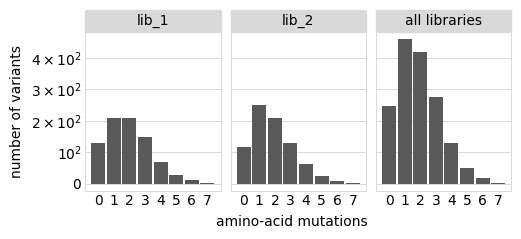

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    )

Plot relationship between simulated and observed phenotypes:

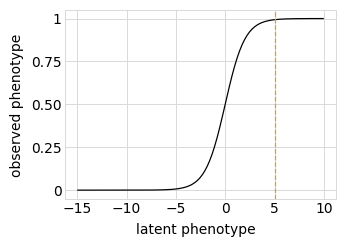

In [10]:
p = phenosimulator.plotLatentVsObserved()
_ = p.draw()

Plot latent and observed phenotypes of all single amino-acid mutants:

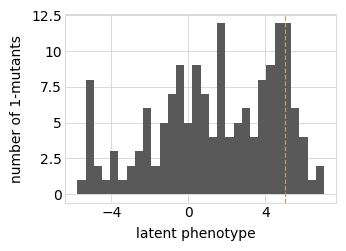

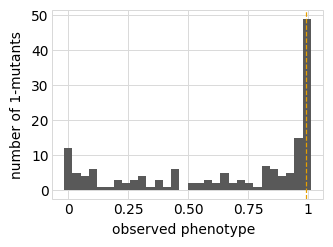

In [11]:
for phenotype in ['latent', 'observed']:
    p = phenosimulator.plotMutsHistogram(phenotype)
    _ = p.draw()

Now we simulate the counts according to the observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedPhenotype,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

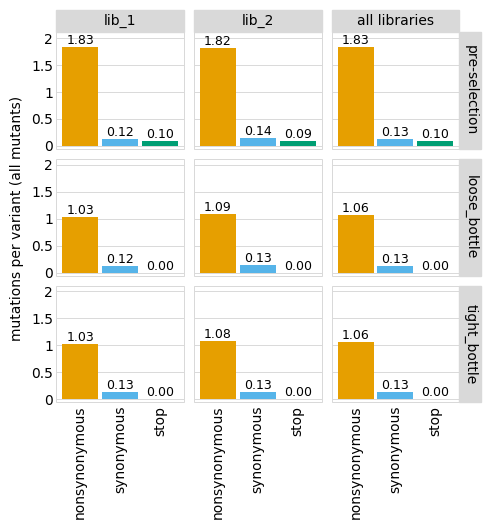

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,1467850,800000,1.834812
1,lib_1,pre-selection,synonymous,99007,800000,0.123759
2,lib_1,pre-selection,stop,78592,800000,0.098240
3,lib_1,loose_bottle,nonsynonymous,826622,800000,1.033278
4,lib_1,loose_bottle,synonymous,95974,800000,0.119968
5,lib_1,loose_bottle,stop,363,800000,0.000454
6,lib_1,tight_bottle,nonsynonymous,825552,800000,1.031940
7,lib_1,tight_bottle,synonymous,104055,800000,0.130069
8,lib_1,tight_bottle,stop,318,800000,0.000398
9,lib_2,pre-selection,nonsynonymous,1456303,800000,1.820379


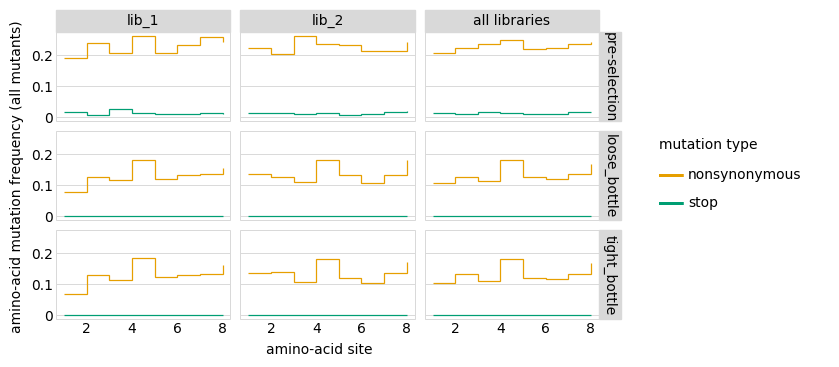

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

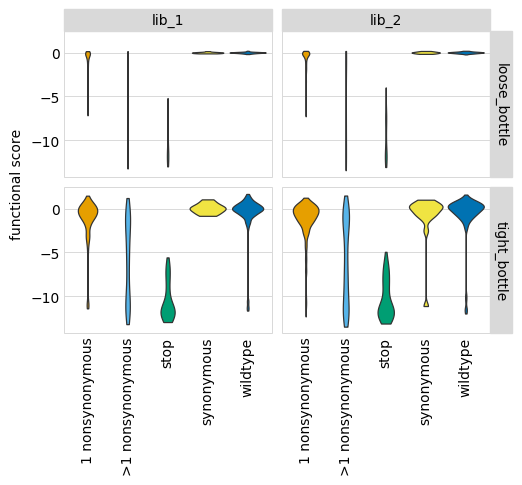

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize `MonotonicSplineEpistasis` model

Focus just on loose bottleneck for now:

In [20]:
func_scores = func_scores.query('post_sample == "loose_bottle"')

Make a binary map for the variants:

In [21]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 160


Now initialize the model:

In [22]:
spline_model = dms_variants.globalepistasis.MonotonicSplineEpistasis(binarymap)

Look at some model attributes:

In [23]:
spline_model.nparams

168

In [24]:
spline_model.epistasis_HOC

1.0

In [25]:
round(spline_model.loglik)

-89528.0

In [26]:
spline_model.latent_phenotype_wt

0.0

In [27]:
for key, val in spline_model.epistasis_func_params_dict.items():
    print(f"{key}: {round(val, 2)}")

c_alpha: -13.43
alpha_1: 2.73
alpha_2: 2.73
alpha_3: 2.73
alpha_4: 2.73
alpha_5: 2.73


Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [28]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Initial least squares fitting
Perform initial least squares optimization followed by rescaling latent effects (normally this is actually performed by the `fit` method):

In [29]:
spline_model._fit_latent_leastsquares()
spline_model._rescale_latent_effects()

Re-check the gradients:

In [30]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

In [31]:
round(spline_model.loglik)

-4265.0


Correlation for latent:
R = 0.947, P = 0

Correlation for observed:
R = 0.928, P = 0


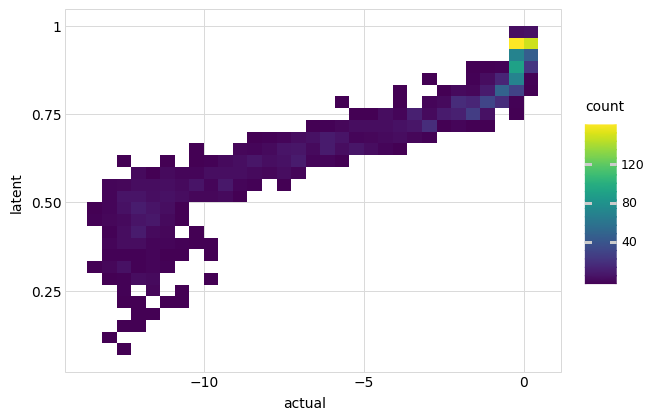

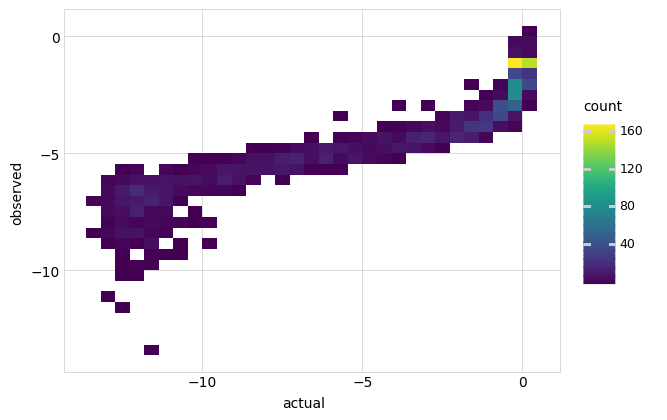

In [32]:
for phenotype in ['latent', 'observed']:
    r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        spline_model.phenotypes_frombinary(binarymap.binary_variants, phenotype)
        )
    print(f"\nCorrelation for {phenotype}:\nR = {r:.3f}, P = {p:.2g}")
    df = pd.DataFrame({'actual': binarymap.func_scores,
                       phenotype: spline_model.phenotypes_frombinary(
                                                   binarymap.binary_variants, phenotype),
                       })

    _ = (ggplot(df, aes('actual', phenotype)) +
         geom_bin2d()
         ).draw()

In [33]:
round(spline_model.epistasis_HOC, 3)

1.422

In [34]:
round(spline_model.latent_phenotype_wt, 3)

0.935

Now fit the model by maximum likelihood:

In [35]:
# NBVAL_IGNORE_OUTPUT
start = time.time()

import cProfile
cProfile.run('spline_model.fit()', '_pstats')
#optres = spline_model.fit()

print(f"Fitting took {time.time() - start:.3f}")

Fitting took 38.410


In [36]:
round(spline_model.loglik)

337.0

In [37]:
round(spline_model.epistasis_HOC, 3)

0.003

In [38]:
round(spline_model.latent_phenotype_wt, 3)

1.089


Correlation for latent:
R = 0.936, P = 0

Correlation for observed:
R = 0.993, P = 0


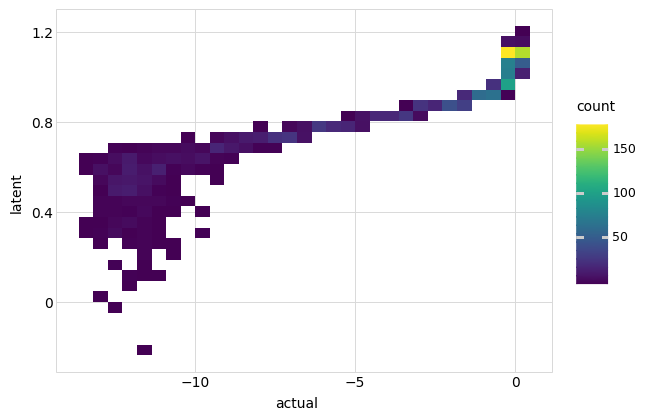

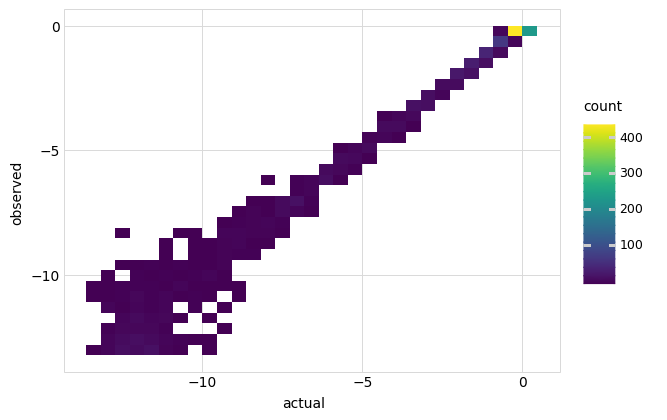

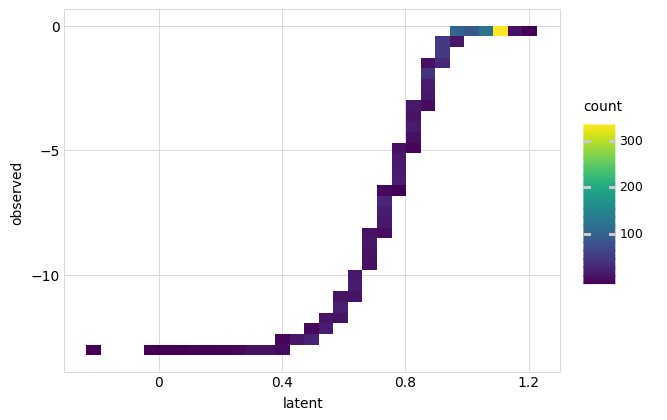

In [39]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'latent': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'latent'),
                   'observed': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'observed'),
                   })

for phenotype in ['latent', 'observed']:
    r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        spline_model.phenotypes_frombinary(binarymap.binary_variants, phenotype)
        )
    print(f"\nCorrelation for {phenotype}:\nR = {r:.3f}, P = {p:.2g}")

    _ = (ggplot(df, aes('actual', phenotype)) +
         geom_bin2d()
         ).draw()
    
_ = (ggplot(df, aes('latent', 'observed')) +
     geom_bin2d()
     ).draw()

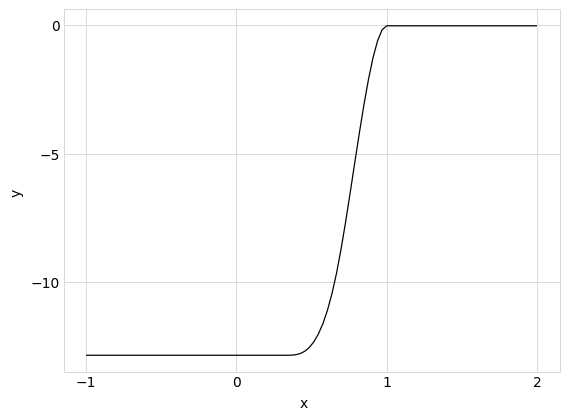

<ggplot: (-9223372036536669829)>

In [40]:
import numpy
xs = numpy.linspace(-1, 2, 100)
df = pd.DataFrame({'x': xs,
                   'y': spline_model.epistasis_func(xs)})

ggplot(df, aes('x', 'y')) + geom_line()

In [41]:
spline_model.loglik

337.24430877333685

In [42]:
spline_model.alpha_ms

array([1.00000000e-08, 1.00000000e-08, 1.00000000e-08, 1.27952930e+01,
       1.59144319e-02])

In [43]:
spline_model.c_alpha

-12.844023365494488

In [44]:
import pstats

s = pstats.Stats('_pstats')
s.strip_dirs()
s.sort_stats('tottime')
s.print_stats(15)

Fri Oct 25 13:33:36 2019    pstats

         30660960 function calls (27712643 primitive calls) in 38.406 seconds

   Ordered by: internal time
   List reduced from 331 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
300636/50106    4.980    0.000   13.940    0.000 ispline.py:1004(_calculate_dM_dx)
267246/183666    3.875    0.000    6.706    0.000 ispline.py:917(_calculate_M)
1150187/866035    2.690    0.000    6.501    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
  1603497    2.363    0.000    6.677    0.000 rope.py:25(__get__)
    55685    1.968    0.000   21.212    0.000 ispline.py:667(<listcomp>)
    55685    1.628    0.000   29.018    0.001 ispline.py:629(_calculate_I_or_dI)
    19489    1.489    0.000   16.798    0.001 {built-in method builtins.sum}
1603497/8358    1.410    0.000   31.810    0.004 methodtools.py:31(__call__)
  1631336    1.056    0.000    2.674    0.000 functools.py:802(wrappe

In [45]:
s.sort_stats('cumtime')
s.print_stats(15)

Fri Oct 25 13:33:36 2019    pstats

         30660960 function calls (27712643 primitive calls) in 38.406 seconds

   Ordered by: cumulative time
   List reduced from 331 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   38.406   38.406 {built-in method builtins.exec}
        1    0.000    0.000   38.406   38.406 <string>:1(<module>)
        1    0.000    0.000   38.406   38.406 globalepistasis.py:485(fit)
        1    0.000    0.000   38.394   38.394 _minimize.py:42(minimize)
        1    0.151    0.151   38.394   38.394 lbfgsb.py:211(_minimize_lbfgsb)
     2786    0.012    0.000   38.237    0.014 lbfgsb.py:284(func_and_grad)
1603497/8358    1.410    0.000   31.810    0.004 methodtools.py:31(__call__)
     8358    0.436    0.000   31.778    0.004 ispline.py:247(_calculate_Itotal_or_dItotal)
    55685    1.628    0.000   29.018    0.001 ispline.py:629(_calculate_I_or_dI)
     2786    0.006    0.000   26.